In [2]:
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
suppressPackageStartupMessages(library(Seurat))
library(pheatmap)
library(RColorBrewer)
library(harmony)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)

library(reticulate)
library(anndata)

Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”
Warning message:
“package ‘sp’ was built under R version 4.4.2”
Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.4.2”
Warning message:
“package ‘scales’ was built under R version 4.4.3”
Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


Warning message:
“package ‘reticulate’ was built under R version 4.4.3”

Attaching package: ‘anndata’


The following object is masked from ‘package:SeuratObject’:

    Layers




In [4]:
hg38 <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed", header = F)
hg38$V4 <- gsub("^([^.]+).*$", "\\1", hg38$V4)
head(hg38)
dim(hg38)

,V1,V2,V3,V4,V5,V6
,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,chr1,11868,14409,+,ENSG00000290825,DDX11L2
2,chr1,29553,31109,+,ENSG00000243485,MIR1302-2HG
3,chr1,34553,36081,-,ENSG00000237613,FAM138A
4,chr1,57597,64116,+,ENSG00000290826,ENSG00000290826
5,chr1,65418,71585,+,ENSG00000186092,OR4F5
6,chr1,89294,133723,-,ENSG00000238009,ENSG00000238009


[1] 38369     6

In [ ]:
tmp <- readRDS("/projects/ps-renlab/ps-renlab2/yangli/projects/HBA/src/stenRNA/stenRNA.annotation.selt.cluster.seObj.rds")
# tmp <- readRDS("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_10XRNA/stenRNA.annotation.selt.cluster.rds")
meta <- tmp@meta.data
meta$umap1 <- tmp@reductions$umap@cell.embeddings[,1]
meta$umap2 <- tmp@reductions$umap@cell.embeddings[,2]
meta %>%
ggplot(aes(x = umap1, y = umap2)) + 
geom_point(size = 0.5, aes(color = Annotation)) + 
theme_classic() + NoLegend()

In [95]:
mtx <- tmp@assays$RNA@counts
tmp <- CreateSeuratObject(mtx)

tmp[["RNA"]] <- as(object = tmp[["RNA"]], Class = "Assay")
tmp <- AddMetaData(tmp, metadata = meta[colnames(tmp),], col.name = colnames(meta))
tmp <- seurat_onestep_clust(tmp, batch.label = "donor", npc = 30, res = 0.3)
gc()

Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“Layer ‘data’ is empty”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Assay RNA changing from Assay5 to Assay”


Perform log CPM normalization...
Perform variable features selection using Brennecke's method...
number of variable genes calculated by hicat method: 5391
Perform data scaling and PCA...


Centering and scaling data matrix



Number of PC selected for downstream analysis: 30


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



Number of neighbors selected for downstream analysis: 15
Perform UMAP embedding...
resolution used for leiden clustering: 0.3


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,13750572,734.4,37009416,1976.6,141179711,7539.9
Vcells,4331706912,33048.4,12393642712,94556.0,20979725740,160062.7


Warning message:
“ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


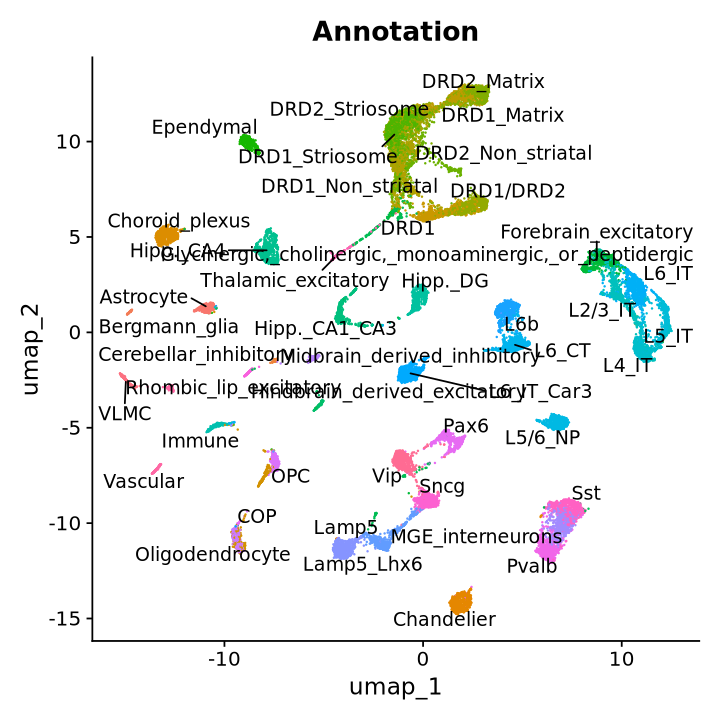

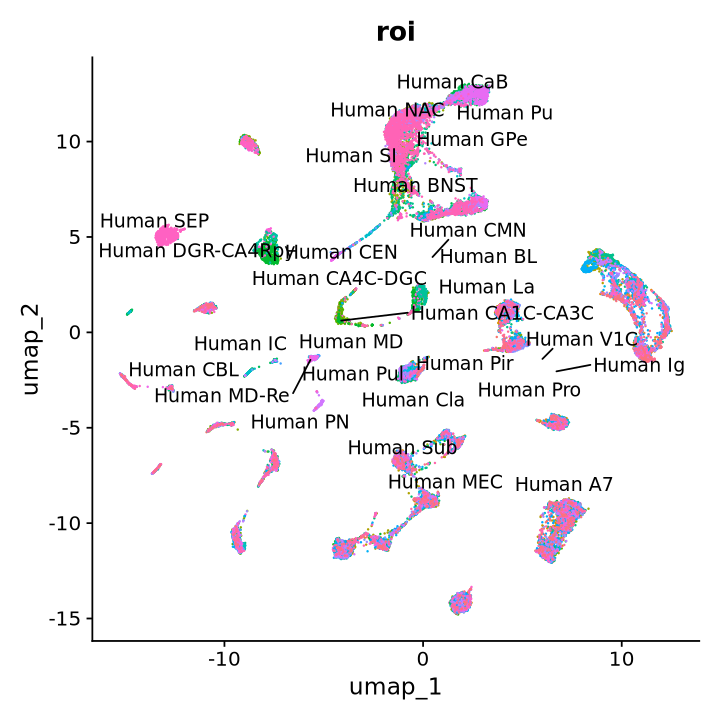

In [103]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(tmp, group.by = "Annotation", label = T, repel = T) + NoLegend()
DimPlot(tmp, group.by = "roi", label = T, repel = T) + NoLegend()

In [158]:
saveRDS(tmp, "stenRNA.annotation.selt.cluster.rds")

In [72]:
tmp <- readRDS("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_10XRNA/stenRNA.annotation.selt.cluster.rds")
intersect(colnames(tmp), rownames(metal)) %>% length ###?

[1] 7911

In [73]:
setdiff(colnames(tmp), rownames(metal)) %>% head

[1] "10X349_2:CCTACGTAGACGGTCA" "10X172_3:GGTCTGGCAGCTCATA"
[3] "10X379_3:CTCCATGGTTTCCAAG" "10X379_4:TATCTGTTCATTGGTG"
[5] "10X349_2:TGCTCGTTCATTCATC" "10X349_2:GGCAGTCCATACTGTG"

In [5]:
l2meta <- read.csv('../../analysis/04.clustering/02.RNA/MiniAtlas_RNA_cortex_cerebellum_240717_rmdoublet_l3_metadata_refined2.txt', sep = "\t", row.names = 1)
obj_list <- list()
for (f in list.files("stenRNA/loomFiles/", pattern = (".*.seObj.rds$"))){
    fname <- gsub("([^.]+).seObj.rds", "\\1", f)
    if (fname %in% unique(l2meta$region)){
        obj_list[[fname]] <- readRDS(paste0("stenRNA/loomFiles/", f))
    }
}

meta_list <- mtx_list <- list()
for (fname in names(obj_list)){
    tmp <- obj_list[[fname]]
    meta_list[[fname]] <- tmp@meta.data
    mtx_list[[fname]] <- tmp@assays$RNA@counts
}

metal <- do.call(rbind, meta_list) 
metal %>% dim
rownames(metal) <- gsub("([^.]+).([^.]+)", "\\2", rownames(metal))

[1] 779825     86

In [9]:
## Subset 2k per annotation (not region!) and integrate
# sten_anno <- read.csv("stenRNA/stenRNA.metatable.txt", sep = "\t") %>% filter(Annotation!= "")
# metal$Annotation <- NA
# good_cells <- intersect(sten_anno$cellID, rownames(metal))
# metal[good_cells, ]$Annotation <- sten_anno[match(good_cells, sten_anno$cellID), ]$Annotation
# metal <- metal[!is.na(metal$Annotation), ]

cts <- list()
i = 1
for (cls in unique(metal$Annotation)){
    if (length(rownames(metal[metal$Annotation == cls,])) > 2000){
        cts[[i]] <- sample(intersect(rownames(metal[metal$Annotation == cls,]), sten_anno$cellID), size = 2000, replace = F)
    }else{
        cts[[i]] <- intersect(rownames(metal[metal$Annotation == cls,]), sten_anno$cellID)
    }
    i = i + 1
}
unlist(cts) %>% length

[1] 49821

In [10]:
obj_list <- lapply(obj_list, function(x) {
    good_cells <- intersect(rownames(x@meta.data), unlist(cts))
    CreateSeuratObject(x@assays$RNA@counts[,good_cells], meta.data = x@meta.data[good_cells,])
})

gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8813289,470.7,17152931,916.1,17152931,916.1
Vcells,7182713461,54799.8,18292716766,139562.4,16975893341,129515.8


### For large scale integration

In [11]:
### use default processing
obj <- merge(obj_list[[1]], y = obj_list[-1])
obj <- seurat_onestep_clust(obj, batch.label = "donor")

Perform log CPM normalization...


Normalizing layer: counts.1

Normalizing layer: counts.2

Normalizing layer: counts.3

Normalizing layer: counts.4

Normalizing layer: counts.5

Normalizing layer: counts.6

Normalizing layer: counts.7

Normalizing layer: counts.8

Normalizing layer: counts.9

Normalizing layer: counts.10

Normalizing layer: counts.11

Normalizing layer: counts.12

Normalizing layer: counts.13

Normalizing layer: counts.14

Normalizing layer: counts.15

Normalizing layer: counts.16

Warning message:
“Joining 'counts' layers. If you have the same cells in multiple layers, the expression value for the cell in the 'counts' slot will be the value from the 'counts.1' layer.”
Warning message:
“Joining 'data' layers. If you have the same cells in multiple layers, the expression value for the cell in the 'data' slot will be the value from the 'data.1' layer.”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:


Perform variable features selection using Brennecke's method...
number of variable genes calculated by hicat method: 5253
Perform data scaling and PCA...


Centering and scaling data matrix



Number of PC selected for downstream analysis: 50


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



Number of neighbors selected for downstream analysis: 15
Perform UMAP embedding...


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


resolution used for leiden clustering: 0.3


In [ ]:
### Using CCA integration...
# obj <- NormalizeData(obj)
# obj <- FindVariableFeatures(obj)
# obj <- ScaleData(obj)
# obj <- RunPCA(obj)
# obj <- IntegrateLayers(obj, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca")
# obj <- FindNeighbors(obj, reduction = "integrated.cca", dims = 1:30)
# obj <- FindClusters(obj, resolution = 1, cluster.name = "cca_clusters")
# obj <- RunUMAP(obj, reduction = "integrated.cca", dims = 1:30, reduction.name = "umap")

In [12]:
obj

An object of class Seurat 
58421 features across 49821 samples within 1 assay 
Active assay: RNA (58421 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


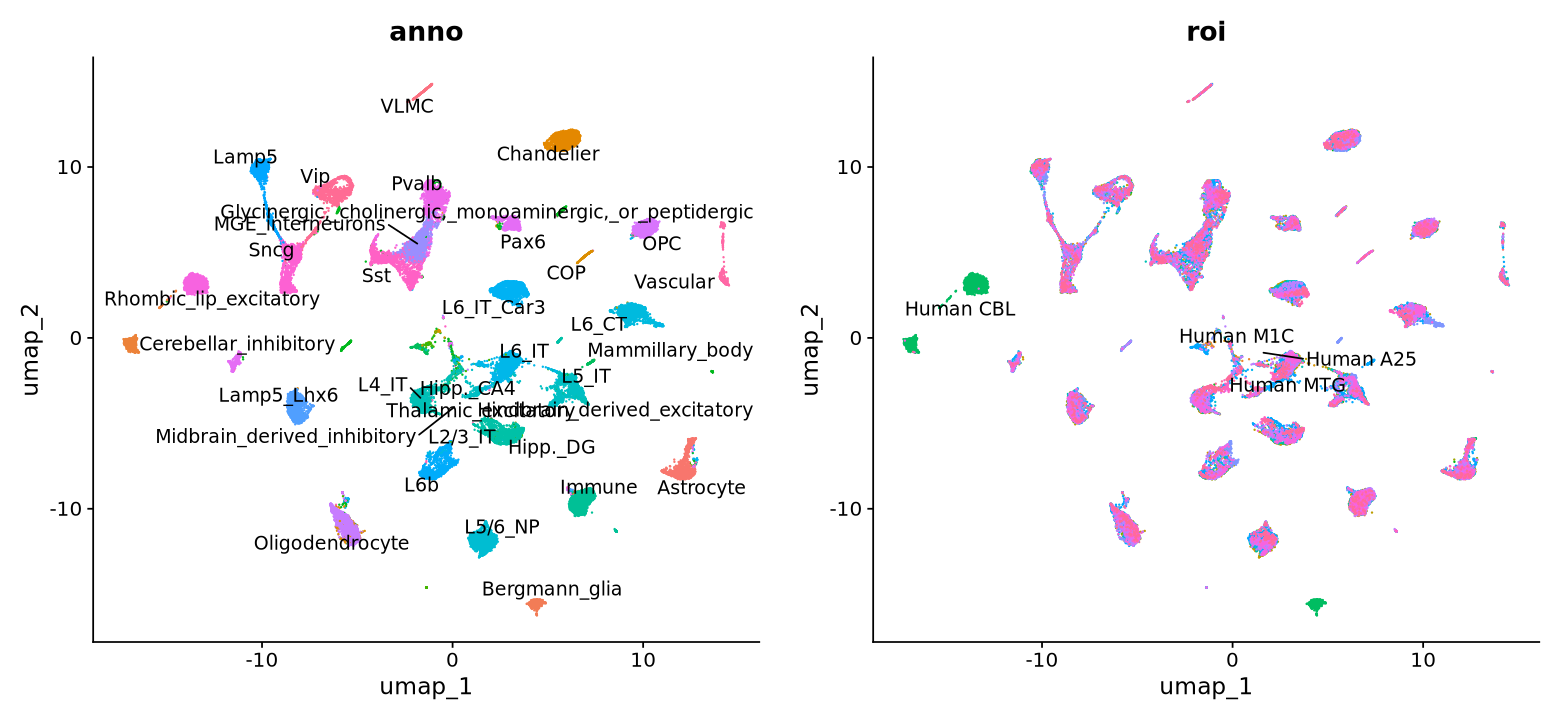

In [13]:
obj$anno <- sten_anno[match(colnames(obj), sten_anno$cellID), ]$Annotation

options(repr.plot.width = 13, repr.plot.height = 6)
t1 <- DimPlot(obj, group.by = "anno", label = T, repel = T) + NoLegend()
t2 <- DimPlot(obj, group.by = "roi", label = T, repel = T) + NoLegend()

cowplot::plot_grid(t1, t2)

In [14]:
qs::qsave(obj, "stenRNA_ctx_cb_region_subsample_by_anno_int.qs", preset = "balanced", nthreads = 32)

In [15]:
obj_list <- NULL
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,23124985,1235.1,74603020,3984.3,93253775,4980.3
Vcells,7742779090,59072.8,18292716766,139562.4,16975893341,129515.8


In [ ]:
mtg <- readRDS("stenRNA/loomFiles/MTG.seObj.rds")
v1c <- readRDS("stenRNA/loomFiles/V1C.seObj.rds")
mtg <- CreateSeuratObject(mtg@assays$RNA@counts, meta.data = mtg@meta.data)
v1c <- CreateSeuratObject(v1c@assays$RNA@counts, meta.data = v1c@meta.data)

mmg <- list(mtg, v1c)
for (i in 1:length(mmg)) {
    mmg[[i]] <- NormalizeData(mmg[[i]], verbose = FALSE)
    mmg[[i]] <- FindVariableFeatures(mmg[[i]], selection.method = "vst", nfeatures = 2000, verbose = FALSE)
}

### Run Integration
obj.anchors <- FindIntegrationAnchors(mmg, dims = 1:50, reduction = "cca", k.anchor = 50)
mmg <- IntegrateData(anchorset = obj.anchors, dims = 1:50)
gc()

DefaultAssay(mmg) <- "integrated"
mmg <- ScaleData(mmg, verbose = FALSE)
mmg <- RunPCA(mmg, npcs = 30, verbose = FALSE)
mmg <- RunUMAP(mmg, reduction = "pca", dims = 1:30, verbose = FALSE)
mmg <- FindNeighbors(mmg, reduction = "pca", dims = 1:30)
mmg <- FindClusters(mmg, resolution = 0.5)

qs::qsave(mmg, "stenRNA_MTG_V1C_int.qs")

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1041820 anchors

Filtering anchors



In [ ]:
gc()
good_cells <- intersect(sten_anno$cellID, colnames(mmg))
mmg$Annotation <- NA
mmg@meta.data[good_cells, ]$Annotation <- sten_anno[good_cells, ]$Annotation

options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(mmg, group.by = "roi", label = T, repel = T) + NoLegend()
DimPlot(mmg, group.by = "Label", label = T, repel = T) + NoLegend()

## Process and subset Siletti dataset using cluster label

In [2]:
rmeta <- read.csv("./analysis/04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_metadata_250520.txt", 
                  sep = "\t", row.names = 1)
unique(rmeta$region)

[1] "A38"   "A5-A7" "CBL"   "A25"   "ITG"   "Idg"   "CBV"   "TH-TL" "A19"  
[10] "A46"   "MEC"   "MTG"   "M1C"   "V1C"   "PN"    "Pro"   "Ig"    "V2"

In [10]:
t1 <- read_h5ad("CELLxGene_rds/siletti_Neu_minialtas_subset.h5ad")
t2 <- read_h5ad("CELLxGene_rds/siletti_NonN_minialtas_subset.h5ad")

In [11]:
mmg <- CreateSeuratObject(counts = cbind(t(t1$X), t(t2$X)), 
                          meta.data = rbind(t1$obs, t2$obs))
mmg

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”


An object of class Seurat 
59236 features across 38577 samples within 1 assay 
Active assay: RNA (59236 features, 0 variable features)
 1 layer present: counts

In [13]:
saveRDS(mmg, "stenRNA.annotation.selt.regionMatch_cluster.rds")

In [14]:
### variable should match!
intersect(unique(hg38$V5), rownames(mmg)) %>% length
intersect(unique(hg38$V6), rownames(mmg)) %>% length
intersect(hg38$V5, rownames(mmg)) %>% length

[1] 35675

[1] 10949

[1] 35675

In [30]:
### Change gene name
mtx <- mmg[["RNA"]]$counts
mtx <- mtx[intersect(unique(hg38$V5), rownames(mmg)),]
rownames(mtx) <- hg38[match(rownames(mtx), hg38$V5),]$V6
rownames(mtx) <- make.unique(rownames(mtx))

In [31]:
obj <- CreateSeuratObject(counts = mtx)
qcol <- setdiff(colnames(mmg@meta.data), colnames(obj@meta.data))
obj <- AddMetaData(obj, metadata = mmg@meta.data[,qcol])

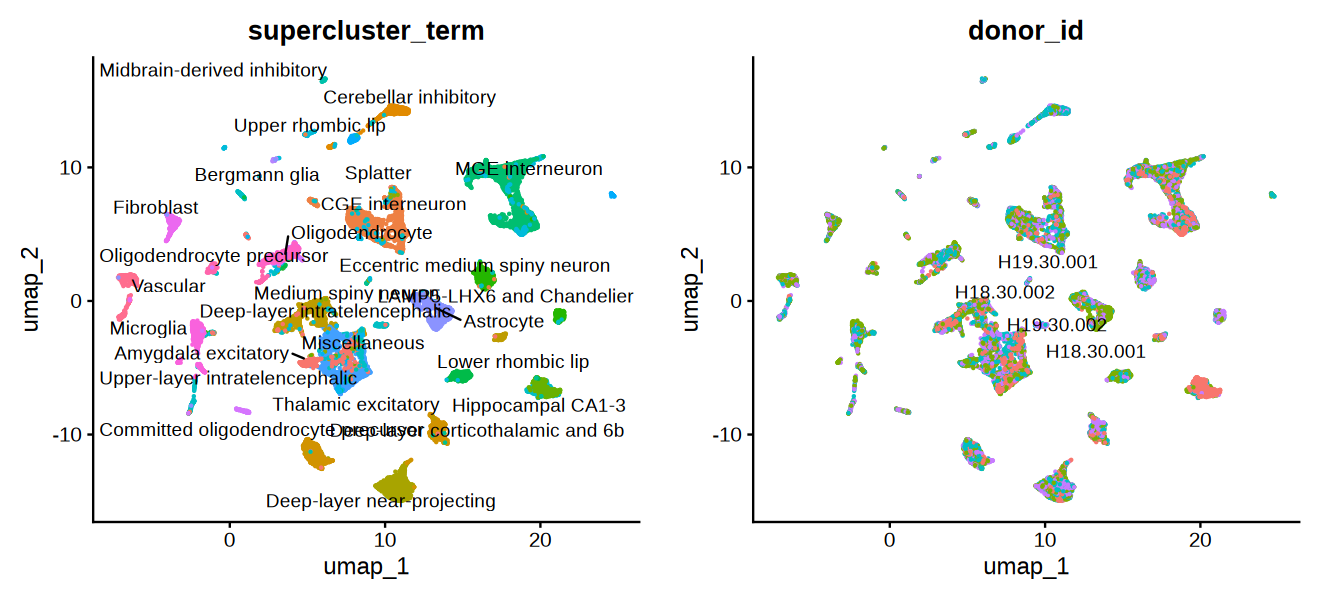

In [35]:
mtx <- CreateAssayObject(counts = obj[["RNA"]]$counts)
obj[["RNA"]] <- mtx
obj <- seurat_onestep_clust(obj, batch.label = "donor_id", res = 0.3)

options(repr.plot.width = 11, repr.plot.height = 5)
t1 <- DimPlot(obj, group.by = "supercluster_term", label = T, repel = T) + NoLegend() #& scale_color_manual(values = col1)
t2 <- DimPlot(obj, group.by = "donor_id", label = T, repel = T) + NoLegend() #& scale_color_manual(values = col2)

cowplot::plot_grid(t1, t2)

In [36]:
saveRDS(obj, "stenRNA.annotation.selt.regionMatch_cluster.genename.rds")